In [1]:
# import some helpful python packages 
import numpy as np
np.random.seed(123)

import json

from astropy.table import Table
from astropy.convolution import convolve, Gaussian1DKernel
import astropy

import matplotlib 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd

%matplotlib inline

In [2]:
# DESI targeting masks - 
from desitarget.sv1 import sv1_targetmask    # For SV1
from desitarget.sv2 import sv2_targetmask    # For SV2
from desitarget.sv3 import sv3_targetmask
from desitarget import __version__ as desitarget_version
from desitarget.targetmask import desi_mask

## DataLab related modules
from sparcl.client import SparclClient
from dl import queryClient as qc, authClient as ac

In [3]:
## Making the matplotlib plots look nicer
settings = {
    'font.size':22,
    'axes.linewidth':3.0,
    'xtick.major.size':6.0,
    'xtick.minor.size':4.0,
    'xtick.major.width':3.0,
    'xtick.minor.width':1.5,
    'xtick.direction':'in', 
    'xtick.minor.visible':True,
    'xtick.top':True,
    'ytick.major.size':6.0,
    'ytick.minor.size':4.0,
    'ytick.major.width':3.0,
    'ytick.minor.width':1.5,
    'ytick.direction':'in', 
    'ytick.minor.visible':True,
    'ytick.right':True
}

plt.rcParams.update(**settings)

In [4]:
## Load SPARCLClient
client = SparclClient()

In [5]:
print(qc.schema('desi_edr'))


Schema: desi_edr

      Table Name   Description
      ----------   -----------
        exposure   Summary quantities for every DESI exposure
     fiberassign   Quantities obtained when a DESI target is assigned to a fiber
           frame   Summary quantities for each petal of the DESI instrument i
                   n a given exposure; in normal operation there are ten fram
                   es for every exposure
      photometry   Photometric quantities from LS DR9 for every TARGETID
       potential   For a given tile, this table lists all targets that could 
                   have received a fiber assignment
          target   The quantities obtained when photometric objects are analy
                   zed in the target selection process
            tile   Summary quantities for every DESI tile (pointing on the sky)
x1p5__zpix__allwise__source   desi_edr.zpix and xmatch_std.allwise__source crossmatch (1
                   .5 arcsec)
x1p5__zpix__gaia_dr3__gaia_source   desi_edr

In [6]:
## Columns in the zpix table
print(qc.schema('desi_edr.zpix'))


Schema: desi_edr
 Table: zpix

     Column Name   Description
     -----------   -----------
               z   Redshift measured by Redrock
            zerr   Redshift error from Redrock
            chi2   Best fit chi squared
         coeff_0   Redrock template coefficients
         coeff_1   Redrock template coefficients
         coeff_2   Redrock template coefficients
         coeff_3   Redrock template coefficients
         coeff_4   Redrock template coefficients
         coeff_5   Redrock template coefficients
         coeff_6   Redrock template coefficients
         coeff_7   Redrock template coefficients
         coeff_8   Redrock template coefficients
         coeff_9   Redrock template coefficients
       deltachi2   Delta-chi-squared for template fit from Redrock
   mean_fiber_ra   Mean (over exposures) RA of actual fiber position
  mean_fiber_dec   Mean (over exposures) DEC of actual fiber position
            elon   Ecliptic longitude
            elat   Ecliptic latitude


In [7]:
query = """
SELECT zp.targetid, zp.survey, zp.program, zp.healpix,  
       zp.z, zp.zwarn, zp.coadd_fiberstatus, zp.spectype, 
       zp.mean_fiber_ra, zp.mean_fiber_dec, zp.zcat_nspec, 
       CAST(zp.zcat_primary AS INT), zp.desi_target,
       zp.sv1_desi_target, zp.sv2_desi_target, zp.sv3_desi_target
FROM desi_edr.zpix AS zp
""" 

## Information about the query
## Selected columns --
## targetid, survey, program -- unique identifiers for a given spectrum
## healpix -- healpix number for the target
## z -- spectroscopic redshift of the target
## zwarn -- encoded information regarding the redshift (zwarn = 0 is good)
## coadd_fiberstatus -- encoded information regarding the fiber that is assigned to the target (coadd_fiberstatus = 0 is good)
## spectype -- Spectral type of the target: STAR | GALAXY | QSO
## mean_fiber_ra, mean_fiber_dec -- Mean R.A. and Dec. of the fiber position from all the observations of the target
## zcat_nspec -- Number of coadded spectra that are available for a given target
## zcat_primary -- Whether or not a given coadded spectra is the primary spectra. ZCAT_PRIMARY = True for the "best" spectrum.
## CASTing this column as an INT: ZCAT_PRIMARY = 1 for the "best" spectrum.
## desi_target -- encodeds main survey's desi targeting information - explained in detail below
## sv1_desi_target -- encodes sv1 desi targeting information
## sv2_desi_target -- encodes sv2 desi targeting information
## sv3_desi_target -- encodes sv3 desi targeting information

In [8]:
print(query)


SELECT zp.targetid, zp.survey, zp.program, zp.healpix,  
       zp.z, zp.zwarn, zp.coadd_fiberstatus, zp.spectype, 
       zp.mean_fiber_ra, zp.mean_fiber_dec, zp.zcat_nspec, 
       CAST(zp.zcat_primary AS INT), zp.desi_target,
       zp.sv1_desi_target, zp.sv2_desi_target, zp.sv3_desi_target
FROM desi_edr.zpix AS zp



In [9]:
%%time
zpix = qc.query(sql = query, fmt = 'pandas')

CPU times: user 2.84 s, sys: 1.57 s, total: 4.4 s
Wall time: 29.3 s


In [10]:
print(f"The resulting table has {len(zpix)} rows")
zpix[0:5]

The resulting table has 2044588 rows


,targetid,survey,program,healpix,z,zwarn,coadd_fiberstatus,spectype,mean_fiber_ra,mean_fiber_dec,zcat_nspec,zcat_primary,desi_target,sv1_desi_target,sv2_desi_target,sv3_desi_target
0,39633414185291967,sv3,dark,15341,0.655598,0,0,GALAXY,273.42926,62.274490,1,1,0,0,0,8457
1,39633414185291844,sv3,bright,15341,0.026611,0,0,GALAXY,273.41397,62.304092,1,1,0,0,0,5764607523034234880
2,39633414185291911,sv3,bright,15341,0.181553,0,0,GALAXY,273.42245,62.343350,1,1,0,0,0,1152921504606846976
3,39633414185291937,sv3,dark,15341,0.832186,0,0,GALAXY,273.42530,62.346302,1,1,0,0,0,8457
4,39633416995473409,sv3,dark,15352,0.673905,4,0,GALAXY,273.45490,62.377106,1,1,0,0,0,4611686018427388932


In [11]:
# Check how many rows have unique TARGETIDs before/after applying the ZCAT_PRIMARY flag
print(f"Total N(rows) : {len(zpix)}")
print(f"N(rows) with unique TARGETIDs : {len(np.unique(zpix['targetid']))}")

is_primary = zpix['zcat_primary']==1

print(f"N(rows) with ZCAT_PRIMARY=True : {len(zpix[is_primary])}")

Total N(rows) : 2044588
N(rows) with unique TARGETIDs : 1979269
N(rows) with ZCAT_PRIMARY=True : 1979269


In [12]:
## Selecting only unique objects
zpix_cat = zpix[is_primary]

In [13]:
# Targeting bits are coded in the sv*_targetmask.desi_mask
sv1_targetmask.desi_mask

sv1_desi_mask:
  - [LRG,              0, "LRG", {'obsconditions': 'DARK', 'priorities': {'UNOBS': 3200, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0, 'MORE_ZWARN': 3200, 'MORE_ZGOOD': 3200}, 'numobs': 2}]
  - [ELG,              1, "ELG", {'obsconditions': 'DARK|GRAY', 'priorities': {'UNOBS': 3000, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0, 'MORE_ZWARN': 3000, 'MORE_ZGOOD': 3000}, 'numobs': 1}]
  - [QSO,              2, "QSO", {'obsconditions': 'DARK', 'priorities': {'UNOBS': 3400, 'MORE_ZGOOD': 3350, 'MORE_ZWARN': 3300, 'MORE_MIDZQSO': 100, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0}, 'numobs': 4}]
  - [LRG_OPT,          3, "LRG from baseline version of optical cuts", {'obsconditions': 'DARK', 'priorities': {'UNOBS': 3200, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0, 'MORE_ZWARN': 3200, 'MORE_ZGOOD': 3200}, 'numobs': 4}]
  - [LRG_IR,           4, "LRG from baseline version of IR cuts", {'obsconditions': 'DARK', 'priorities': {'UNOBS': 3200, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0, 'MORE_ZWARN': 3200, 'MO

In [14]:
# A few example bitmask values

print(sv1_targetmask.desi_mask.mask("STD_BRIGHT"), sv1_targetmask.desi_mask.mask("STD_BRIGHT"), sv1_targetmask.desi_mask.mask("STD_FAINT|STD_BRIGHT"))
print(2**33, 2**35, 2**33 + 2**35)

34359738368 34359738368 42949672960
8589934592 34359738368 42949672960


In [15]:
# Targeting information about the DESI targetting is stored in the different desi_target columns
# sv1_targetmask.desi_mask corresponds to SV1_DESI_TARGET
# sv2_targetmask.desi_mask corresponds to SV2_DESI_TARGET
# sv3_targetmask.desi_mask corresponds to SV3_DESI_TARGET

sv1_desi_tgt = zpix_cat['sv1_desi_target']
sv2_desi_tgt = zpix_cat['sv2_desi_target']
sv3_desi_tgt = zpix_cat['sv3_desi_target']

## DESI Bitmasks
sv1_desi_mask = sv1_targetmask.desi_mask
sv2_desi_mask = sv2_targetmask.desi_mask
sv3_desi_mask = sv3_targetmask.desi_mask

In [16]:
# Selecting candidates - 

is_bgs = (sv1_desi_tgt & sv1_desi_mask['BGS_ANY'] != 0)|(sv2_desi_tgt & sv2_desi_mask['BGS_ANY'] != 0)|(sv3_desi_tgt & sv3_desi_mask['BGS_ANY'] != 0)
is_lrg = (sv1_desi_tgt & sv1_desi_mask['LRG'] != 0)|(sv2_desi_tgt & sv2_desi_mask['LRG'] != 0)|(sv3_desi_tgt & sv3_desi_mask['LRG'] != 0)
is_elg = (sv1_desi_tgt & sv1_desi_mask['ELG'] != 0)|(sv2_desi_tgt & sv2_desi_mask['ELG'] != 0)|(sv3_desi_tgt & sv3_desi_mask['ELG'] != 0)
is_qso = (sv1_desi_tgt & sv1_desi_mask['QSO'] != 0)|(sv2_desi_tgt & sv2_desi_mask['QSO'] != 0)|(sv3_desi_tgt & sv3_desi_mask['QSO'] != 0)
is_mws = (sv1_desi_tgt & sv1_desi_mask['MWS_ANY'] != 0)|(sv2_desi_tgt & sv2_desi_mask['MWS_ANY'] != 0)|(sv3_desi_tgt & sv3_desi_mask['MWS_ANY'] != 0)
is_scnd = (sv1_desi_tgt & sv1_desi_mask['SCND_ANY'] != 0)|(sv2_desi_tgt & sv2_desi_mask['SCND_ANY'] != 0)|(sv3_desi_tgt & sv3_desi_mask['SCND_ANY'] != 0)

In [17]:
elg = zpix_cat[is_elg]

In [18]:
# created a mask to only show the galaxies within the ELG query. Which removes the QSO that are marked

mask2 = (elg['spectype'].values == 'GALAXY')&(elg['z']<=1.5)&(elg['z']>0.5)
new_elg_sample = elg.loc[mask2]
new_elg_sample

,targetid,survey,program,healpix,z,zwarn,coadd_fiberstatus,spectype,mean_fiber_ra,mean_fiber_dec,zcat_nspec,zcat_primary,desi_target,sv1_desi_target,sv2_desi_target,sv3_desi_target
7,39633402705479329,sv3,dark,15342,1.073187,0,0,GALAXY,272.28238,61.296240,1,1,0,0,0,3622
8,39633402705479200,sv3,dark,15342,1.073464,0,0,GALAXY,272.26596,61.303337,1,1,0,0,0,4674
11,39633402701288119,sv3,dark,15339,0.859081,0,0,GALAXY,272.06757,61.213963,1,1,0,0,0,4674
14,39633402705478711,sv3,dark,15342,1.008903,0,0,GALAXY,272.20126,61.258810,1,1,0,0,0,4611686018427393606
23,39633402705478163,sv3,dark,15342,1.277754,0,0,GALAXY,272.13297,61.263810,1,1,0,0,0,4674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2037053,39633127735297217,sv3,dark,9984,1.368138,0,0,GALAXY,248.01155,42.791690,1,1,0,0,0,5702
2037055,39633127735296909,sv3,dark,9984,1.368587,0,0,GALAXY,247.98990,42.801674,1,1,0,0,0,4674
2037057,39633127735297637,sv3,dark,9984,1.240138,0,0,GALAXY,248.04396,42.806860,1,1,0,0,0,4674
2037062,39633127735297831,sv3,dark,9984,1.351391,0,0,GALAXY,248.05916,42.832130,1,1,0,0,0,4674


Text(0.5, 0, 'Redshift')

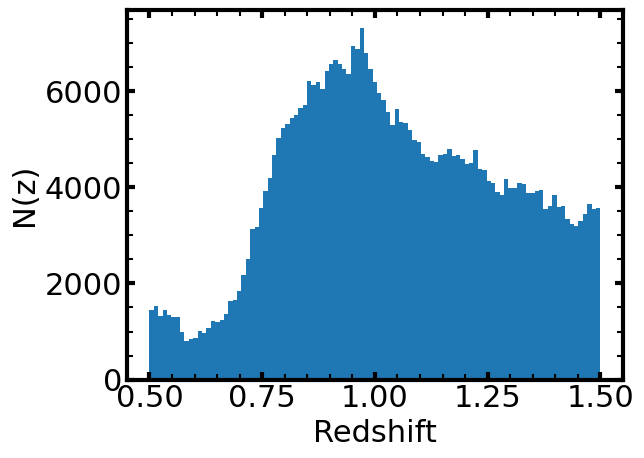

In [19]:
# distribution of ELG Sample after the filtering

plt.hist(new_elg_sample['z'], bins = 'auto')
plt.ylabel('N(z)')
plt.xlabel('Redshift')

In [20]:
## Select QSO with nspec > 3 (nspec is just the number of available spectra)

jj = (zpix_cat['zcat_nspec'] >= 1)&(zpix_cat['spectype'] == 'QSO')&(zpix_cat['z']<=1.8)&(zpix_cat['z']>=0.03)
QSO_spec = zpix_cat[jj]

In [21]:
# Just plotting the table

QSO_spec

,targetid,survey,program,healpix,z,zwarn,coadd_fiberstatus,spectype,mean_fiber_ra,mean_fiber_dec,zcat_nspec,zcat_primary,desi_target,sv1_desi_target,sv2_desi_target,sv3_desi_target
18,39633402705478701,sv3,dark,15342,1.214614,0,0,QSO,272.19968,61.302803,1,1,0,0,0,4611686018427388932
62,39633399773662775,sv3,dark,15339,1.373077,0,0,QSO,271.65024,61.116356,1,1,0,0,0,4611686018427388932
100,39633402701287685,sv3,dark,15342,1.263618,0,0,QSO,272.01600,61.302017,1,1,0,0,0,4611686018427393606
136,39633402701285280,sv3,dark,15339,1.224640,0,0,QSO,271.75784,61.184500,1,1,0,0,0,4611686018427388932
245,39633408489427354,sv3,dark,15340,1.594372,0,0,QSO,272.80756,61.628307,1,1,0,0,0,1028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2044561,39632997007229862,special,dark,14886,0.377824,0,0,QSO,278.93990,35.718533,1,1,4611686018427388932,0,0,0
2044564,39632997007233273,special,dark,14886,1.458692,4,0,QSO,279.07462,35.674126,1,1,4611686018427388932,0,0,0
2044565,39632997007231881,special,dark,14886,1.064800,0,0,QSO,279.01830,35.731236,1,1,4611686018427388932,0,0,0
2044573,39632997007234001,special,dark,14886,1.253875,0,0,QSO,279.10287,35.703410,1,1,4611686018427388932,0,0,0


Text(0.5, 0, 'Redshift')

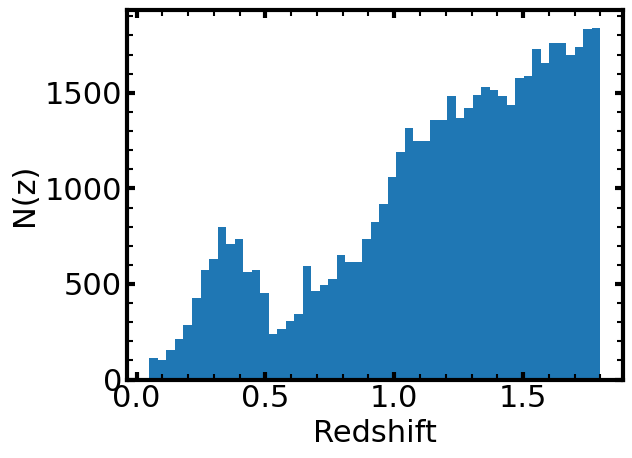

In [22]:
# distribution of ELG Sample after the filtering

plt.hist(QSO_spec['z'], bins = 'auto')
plt.ylabel('N(z)')
plt.xlabel('Redshift')

In [23]:
new_dist_qso = QSO_spec.sample(frac = .1)

In [24]:
len(new_dist_qso)

5159

Text(0.5, 0, 'Redshift')

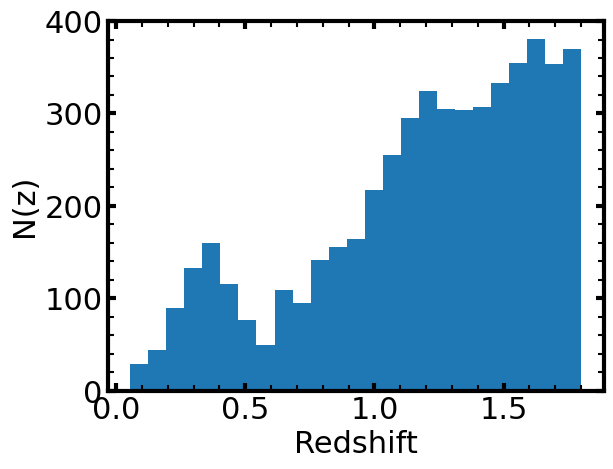

In [25]:
# distribution of ELG Sample after the filtering

plt.hist(new_dist_qso['z'], bins = 'auto')
plt.ylabel('N(z)')
plt.xlabel('Redshift')

In [69]:
new_dist_elg = new_elg_sample.sample(frac = .5)


In [70]:
len(new_dist_elg)

208234

In [71]:
frames = [new_dist_elg, new_dist_qso]

In [72]:
new_frame = pd.concat(frames
         )

(array([3.000e+00, 1.000e+01, 3.000e+00, 6.000e+00, 5.000e+00, 4.000e+00,
        7.000e+00, 6.000e+00, 8.000e+00, 9.000e+00, 7.000e+00, 1.100e+01,
        1.200e+01, 1.500e+01, 1.800e+01, 1.400e+01, 2.700e+01, 1.500e+01,
        2.900e+01, 2.200e+01, 2.300e+01, 3.200e+01, 2.300e+01, 2.900e+01,
        2.700e+01, 3.400e+01, 2.400e+01, 2.700e+01, 3.300e+01, 1.200e+01,
        2.200e+01, 1.500e+01, 2.000e+01, 2.300e+01, 1.700e+01, 4.000e+01,
        9.600e+02, 9.380e+02, 9.100e+02, 8.480e+02, 8.680e+02, 7.280e+02,
        5.220e+02, 5.450e+02, 5.980e+02, 6.210e+02, 6.690e+02, 7.740e+02,
        8.400e+02, 8.540e+02, 1.058e+03, 1.097e+03, 1.304e+03, 1.535e+03,
        2.000e+03, 2.127e+03, 2.418e+03, 2.672e+03, 3.097e+03, 3.378e+03,
        3.326e+03, 3.504e+03, 3.615e+03, 3.590e+03, 3.946e+03, 3.832e+03,
        3.933e+03, 3.936e+03, 4.187e+03, 4.210e+03, 4.155e+03, 4.119e+03,
        4.451e+03, 4.358e+03, 4.600e+03, 4.151e+03, 3.904e+03, 3.873e+03,
        3.620e+03, 3.426e+03, 3.723e+0

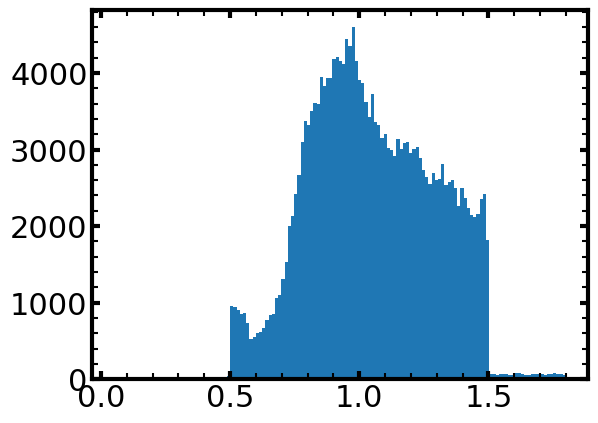

In [73]:
plt.hist(new_frame['z'], bins = 'auto', label = 'elg')

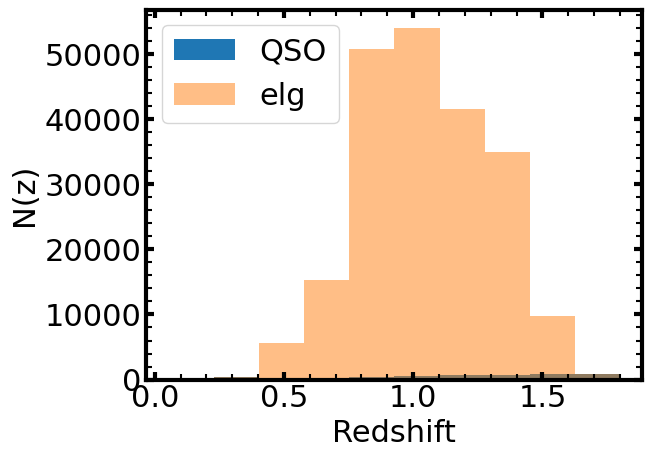

In [74]:
plt.hist(new_dist_qso['z'], label = 'QSO')
plt.hist(new_frame['z'], label = 'elg', alpha = .5)

plt.ylabel('N(z)')
plt.xlabel('Redshift')
plt.legend()



# Adding Fluxes

Now we have to add the fluxes of the objects but only if the redshift is is less than the QSO

In [75]:
lense_qso = QSO_spec.sample(frac = .1)

In [76]:
lense_qso

,targetid,survey,program,healpix,z,zwarn,coadd_fiberstatus,spectype,mean_fiber_ra,mean_fiber_dec,zcat_nspec,zcat_primary,desi_target,sv1_desi_target,sv2_desi_target,sv3_desi_target
173237,39633158332744858,sv3,dark,9848,1.557198,0,0,QSO,241.60535,44.574430,1,1,0,0,0,4611686018427388932
1330378,39627799811590803,sv3,dark,26965,1.501920,0,0,QSO,179.13167,0.420997,1,1,0,0,0,4611686018427650052
1539547,39628279023406627,special,dark,10242,1.721946,0,0,QSO,201.29118,20.653595,1,1,262148,0,0,0
1325876,39627793771791123,sv3,dark,26965,1.499006,0,0,QSO,179.04356,0.202531,1,1,0,0,0,4611686018427650052
1980919,39632971891740153,sv3,dark,9428,1.768471,0,0,QSO,251.92816,34.620564,1,1,0,0,0,1028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1512209,39628346102909861,sv3,dark,28116,1.605758,0,0,QSO,195.42801,23.837465,2,1,0,0,0,1441862
502,39633408489424884,sv3,dark,15340,1.320221,0,0,QSO,272.55590,61.738316,1,1,0,0,0,1028
1844960,39632966405588273,sv3,dark,10515,1.293561,0,0,QSO,216.59143,34.349415,1,1,0,0,0,4674
493312,39633275190250300,sv3,dark,10741,1.174689,0,0,QSO,213.69730,51.788430,1,1,0,0,0,5702


(array([ 229.,  870.,  592.,  553.,  831., 1487., 1860., 1944., 2126.,
        2405.]),
 array([0.05      , 0.22498616, 0.39997232, 0.57495849, 0.74994465,
        0.92493081, 1.09991697, 1.27490314, 1.4498893 , 1.62487546,
        1.79986162]),
 <BarContainer object of 10 artists>)

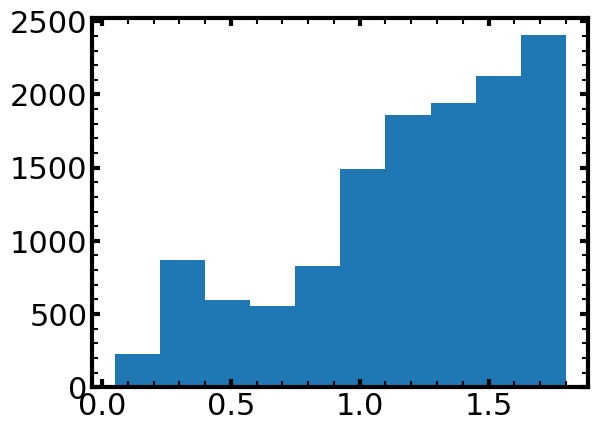

In [34]:
plt.hist(lense_qso['z'])

In [77]:
lense_qso['z'].iloc[3798]

0.796819527144818

In [78]:
new_elg_dist = new_elg_sample.sample(frac=.1)

In [79]:
len(new_elg_dist), len(lense_qso)

(41647, 5159)

(array([ 99., 338., 248., 248., 339., 583., 692., 773., 867., 972.]),
 array([0.05003235, 0.22502781, 0.40002328, 0.57501875, 0.75001422,
        0.92500968, 1.10000515, 1.27500062, 1.44999609, 1.62499155,
        1.79998702]),
 <BarContainer object of 10 artists>)

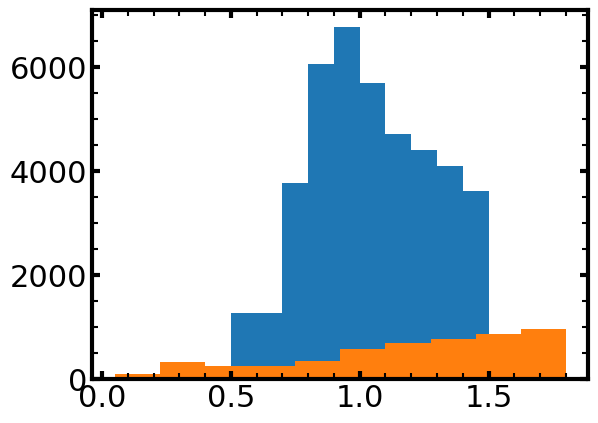

In [80]:
plt.hist(new_elg_dist['z'])
plt.hist(lense_qso['z'])

## Creating the new table for lenses

First we should define a function that retrieves the spectrum of that QSO if the redshift is less than the ELGs redshift

In [39]:
#function to create a table and create a panda table
def Spectrum_qso(jj):
    
    targetid_QSO = int(lense_qso['targetid'].iloc[jj])
    inc_qso = ['specid', 'redshift', 'flux', 'ivar', 'wavelength', 'spectype', 'specprimary', 'survey', 'program', 'targetid', 'coadd_fiberstatus']
    res_qso = client.retrieve_by_specid(specid_list = [targetid_QSO], include = inc_qso, dataset_list = ['DESI-EDR'])
    records_qso = res_qso.records

    ## Select the primary spectrum
    spec_primary_qso = np.array([records_qso[j].specprimary for j in range(len(records_qso))])
    primary_ii_qso = np.where(spec_primary_qso == True)[0][0]
    lam_primary_qso = np.asarray(records_qso[primary_ii_qso].wavelength)
    flam_primary_qso = np.asarray(records_qso[primary_ii_qso].flux)
    redshift_qso = np.asarray(records_qso[primary_ii_qso].redshift)
    
    table = pd.DataFrame({'Wavelength': lam_primary_qso, 'Flux': flam_primary_qso, 'Redshift':redshift_qso}, columns=['Wavelength', 'Flux', 'Redshift'])
    
    return(table)

# function for elg 
def Spectrum_elg(jj):
    
    targetid_elg = int(new_elg_dist['targetid'].iloc[jj])
    inc_elg = ['specid', 'redshift', 'flux', 'ivar', 'wavelength', 'spectype', 'specprimary', 'survey', 'program', 'targetid', 'coadd_fiberstatus']
    res_elg = client.retrieve_by_specid(specid_list = [targetid_elg], include = inc_elg, dataset_list = ['DESI-EDR'])
    records_elg = res_elg.records

    ## Select the primary spectrum
    spec_primary_elg = np.array([records_elg[j].specprimary for j in range(len(records_elg))])
    primary_ii_elg = np.where(spec_primary_elg == True)[0][0]
    lam_primary_elg = np.asarray(records_elg[primary_ii_elg].wavelength)
    flam_primary_elg = np.asarray(records_elg[primary_ii_elg].flux)
    redshift_elg = np.asarray(records_elg[primary_ii_elg].redshift)
    
    table_elg = pd.DataFrame({'Wavelength': lam_primary_elg, 'Flux': flam_primary_elg, 'Redshift':redshift_elg}, columns=['Wavelength', 'Flux', 'Redshift'])
    return(table_elg)

# function to add them
def Lensing(QSO, ELG):
    Flux_add = QSO['Flux'] + ELG['Flux']
    lam_primary_elg = ELG['Wavelength']
    table_lense = pd.DataFrame({'Wavelength': lam_primary_elg, 'Flux': Flux_add}, columns=['Wavelength', 'Flux'])
    return(table_lense)
                

## Training Sample for the un-Lensed

In [40]:
def Spectrum_qso_nolense(jj):
    
    targetid_QSO = int(new_dist_qso['targetid'].iloc[jj])
    inc_qso = ['specid', 'redshift', 'flux', 'ivar', 'wavelength', 'spectype', 'specprimary', 'survey', 'program', 'targetid', 'coadd_fiberstatus']
    res_qso = client.retrieve_by_specid(specid_list = [targetid_QSO], include = inc_qso, dataset_list = ['DESI-EDR'])
    records_qso = res_qso.records

    ## Select the primary spectrum
    spec_primary_qso = np.array([records_qso[j].specprimary for j in range(len(records_qso))])
    primary_ii_qso = np.where(spec_primary_qso == True)[0][0]
    lam_primary_qso = np.asarray(records_qso[primary_ii_qso].wavelength)
    flam_primary_qso = np.asarray(records_qso[primary_ii_qso].flux)
    redshift_qso = np.asarray(records_qso[primary_ii_qso].redshift)
    
    table = pd.DataFrame({'Wavelength': lam_primary_qso, 'Flux': flam_primary_qso}, columns=['Wavelength', 'Flux'])
    
    return(table)

# function for elg 
def Spectrum_elg_nolense(jj):
    
    targetid_elg = int(new_dist_elg['targetid'].iloc[jj])
    inc_elg = ['specid', 'redshift', 'flux', 'ivar', 'wavelength', 'spectype', 'specprimary', 'survey', 'program', 'targetid', 'coadd_fiberstatus']
    res_elg = client.retrieve_by_specid(specid_list = [targetid_elg], include = inc_elg, dataset_list = ['DESI-EDR'])
    records_elg = res_elg.records

    ## Select the primary spectrum
    spec_primary_elg = np.array([records_elg[j].specprimary for j in range(len(records_elg))])
    primary_ii_elg = np.where(spec_primary_elg == True)[0][0]
    lam_primary_elg = np.asarray(records_elg[primary_ii_elg].wavelength)
    flam_primary_elg = np.asarray(records_elg[primary_ii_elg].flux)
    redshift_elg = np.asarray(records_elg[primary_ii_elg].redshift)
    
    table_elg = pd.DataFrame({'Wavelength': lam_primary_elg, 'Flux': flam_primary_elg, 'Redshift':redshift_elg}, columns=['Wavelength', 'Flux', 'Redshift'])
    return(table_elg)

In [41]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

spectra = []
redshift = []
name = []
classifier = []

for f in range(0,2):
    '''
    unLensed creation:
    =====================

    Runs through each QSO and puts it into the hdf5 file.

    '''

    QSO_Spec = Spectrum_qso_nolense(f)
    targetid_name = str(new_dist_qso['targetid'].iloc[f])
    intuitive_id = str(targetid_name + 'q')
    redshift_qso = new_dist_qso['z'].iloc[f]
    classif = 'QSO'
    
    classifier.append(classif)
    name.append(intuitive_id)
    spectra.append(QSO_Spec)
    redshift.append(redshift_qso)
    
    #save_table_to_file(targetid_name +'qso', QSO_Spec)
    

for i in range(0,2):
    '''
    Lensed creation:
    =====================

    The below lines iterate through each row of the elg sample and for each iteration 
    it finds QSO's with a redshift that less than the elg.

    It then randomly selects the index after transposing the the row to a column of indices from the QSO redshift list.

    It then finds the length of that column and randomly selects the index of the column number. 

    Then uses that index to index the qso sample that has a z< the z of the elg. Then uses the functions in the previous cell to extract the spectrum of 
    the elg and qso and returns the added flux table and wavelength.

    '''
    locate_elg = new_elg_dist['z'].iloc[i]
    find_lowz_qso = np.where(lense_qso['z'] <= locate_elg)
    row_to_column = np.transpose(find_lowz_qso)
    index_lowz = np.random.choice(len(row_to_column))
    new_index = int(row_to_column[index_lowz])
    higher_red = lense_qso['z'].iloc[new_index]

    QSO_Table = Spectrum_qso(new_index)
    ELG_table = Spectrum_elg(i)
    lense = Lensing(QSO_Table, ELG_table)
    index = str(lense_qso['targetid'].iloc[i])
    elg_name = str(new_elg_dist['targetid'].iloc[i])
    elg_QSO = str(index + '+' + elg_name)
    classification = 'lense'
    
    classifier.append(classification)
    name.append(elg_QSO)
    spectra.append(lense)
    redshift.append(higher_red)
    
    

In [43]:
data_dict = {
    'spectra': np.asarray(spectra),
    'redshift': redshift,
    'type': classifier,
    'name': name
}

In [44]:
data_dict

{'spectra': array([[[ 3.60000000e+03, -6.27325249e+00],
         [ 3.60080000e+03, -2.85573554e+00],
         [ 3.60160000e+03, -9.97315824e-01],
         ...,
         [ 9.82240000e+03,  1.07263796e-01],
         [ 9.82320000e+03,  4.03514057e-01],
         [ 9.82400000e+03,  2.43302554e-01]],
 
        [[ 3.60000000e+03,  8.31179082e-01],
         [ 3.60080000e+03,  3.71958613e+00],
         [ 3.60160000e+03,  5.58214474e+00],
         ...,
         [ 9.82240000e+03, -9.92089733e-02],
         [ 9.82320000e+03,  5.17091990e-01],
         [ 9.82400000e+03,  4.29423153e-01]],
 
        [[ 3.60000000e+03,  1.34418042e+01],
         [ 3.60080000e+03, -1.18054457e+01],
         [ 3.60160000e+03, -1.27914618e+01],
         ...,
         [ 9.82240000e+03,  2.69583671e+00],
         [ 9.82320000e+03,  3.62155714e+00],
         [ 9.82400000e+03,  2.31116560e+00]],
 
        [[ 3.60000000e+03, -1.82995043e+01],
         [ 3.60080000e+03, -2.20153103e+01],
         [ 3.60160000e+03, -4.68604906

In [45]:
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [81]:
os.getcwd()

'/Users/emac/Library/CloudStorage/GoogleDrive-edm2158@stanford.edu/My Drive/AGN_Project/Lensing-Project'

In [46]:
import os

home = os.getcwd()

In [47]:
json_file_path = home + '/Testingsample/data.json'

directory = os.path.dirname(json_file_path)
if not os.path.exists(directory):
    os.makedirs(directory)
    
if os.path.exists(json_file_path):
    print("JSON file exists. Deleting and creating a new one.")
    os.remove(json_file_path)

# Write the new data to the JSON file
with open(json_file_path, 'w') as json_file:
    json.dump(data_dict, json_file, cls = NpEncoder, indent=4)

JSON file exists. Deleting and creating a new one.


# File test

In [48]:
with open(json_file_path, "r") as json_file:
    data_dict = json.load(json_file)

In [49]:
keys_list = list(data_dict.keys())

In [50]:
keys_list

['spectra', 'redshift', 'type', 'name']

In [55]:
data_dict['name'][1], 
data_dict['redshift'][1], 
data_dict['type'][1], 
pd.DataFrame(data_dict['spectra'][1])

('39632941055214495q',
 1.5702517821127198,
 'QSO',
            0         1
 0     3600.0  0.831179
 1     3600.8  3.719586
 2     3601.6  5.582145
 3     3602.4  1.410905
 4     3603.2  2.749400
 ...      ...       ...
 7776  9820.8  0.398830
 7777  9821.6  0.274036
 7778  9822.4 -0.099209
 7779  9823.2  0.517092
 7780  9824.0  0.429423
 
 [7781 rows x 2 columns])

In [67]:
from operator import itemgetter
itemgetter('name', 'redshift', 'type', 'spectra')(data_dict)

(['39628368169141527q',
  '39632941055214495q',
  '39633483139646961+39633402017614070',
  '39633308434302712+39632981857406457'],
 [1.2064763650819723,
  1.5702517821127198,
  0.2743210625675873,
  1.3741383250767227],
 ['QSO', 'QSO', 'lense', 'lense'],
 [[[3600.0, -6.273252487182617],
   [3600.8, -2.8557355403900146],
   [3601.6000000000004, -0.9973158240318298],
   [3602.4000000000005, -4.059504985809326],
   [3603.2000000000007, 0.06384822726249695],
   [3604.000000000001, -2.295612335205078],
   [3604.800000000001, 4.5823445320129395],
   [3605.6000000000013, -2.9184682369232178],
   [3606.4000000000015, 0.9553117752075195],
   [3607.2000000000016, -4.839976787567139],
   [3608.000000000002, -1.7687838077545166],
   [3608.800000000002, 4.796334266662598],
   [3609.600000000002, 2.771512031555176],
   [3610.4000000000024, -4.509125232696533],
   [3611.2000000000025, 1.6867743730545044],
   [3612.0000000000027, -0.5627923607826233],
   [3612.800000000003, 1.3795076608657837],
   [36

In [ ]:
spec = pd.DataFrame(data_dict['spectra'][1])

In [ ]:
x = spec[0]
y = spec[1]

In [ ]:
plt.figure(figsize = (20, 6))
plt.plot(x,y)